# TekCollection Test Harness  
### Thomas Ales | June 2020  
-----
Testing for TekCollection functionality.

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import MapCollection
import pickle

In [2]:
data_dir_prefix = '/home/tka/source/data/customer042/PostFix/'
data_dirs = ['TestScan_000', 'TestScan_020', 'TestScan_040', 'TestScan_060',
             'TestScan_080', 'TestScan_100', 'TestScan_120', 'TestScan_140',
             'TestScan_160']
t_data_dir_prefix = '/home/tka/source/data/customer042/PostFix/Cutset/'
t_data_dirs = ['000', '020', '040', '060', '080', '100', '120', '140', '160']

In [3]:
#data_dir_prefix = t_data_dir_prefix
#data_dirs = t_data_dirs

In [4]:
abspathlist = []
for current in data_dirs:
    abspathlist.append(data_dir_prefix + current)

abspathlist

['/home/tka/source/data/customer042/PostFix/TestScan_000',
 '/home/tka/source/data/customer042/PostFix/TestScan_020',
 '/home/tka/source/data/customer042/PostFix/TestScan_040',
 '/home/tka/source/data/customer042/PostFix/TestScan_060',
 '/home/tka/source/data/customer042/PostFix/TestScan_080',
 '/home/tka/source/data/customer042/PostFix/TestScan_100',
 '/home/tka/source/data/customer042/PostFix/TestScan_120',
 '/home/tka/source/data/customer042/PostFix/TestScan_140',
 '/home/tka/source/data/customer042/PostFix/TestScan_160']

In [5]:
mc = MapCollection.TekCollection(abspathlist, "")

In [7]:
mc.initalize_maps()

Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files



In [8]:
mc.process_dc()
#test = pickle.load(open('/home/tka/source/data/voltage_test_data.p', 'rb'))


In [9]:
#mc.process_fft()
test = pickle.load(open('/home/tka/source/data/fft_test_data.p', 'rb'))
for idx, current in enumerate(test):
    mc.map_collections[idx].rf_map = current

In [10]:
mc.process_velocity()

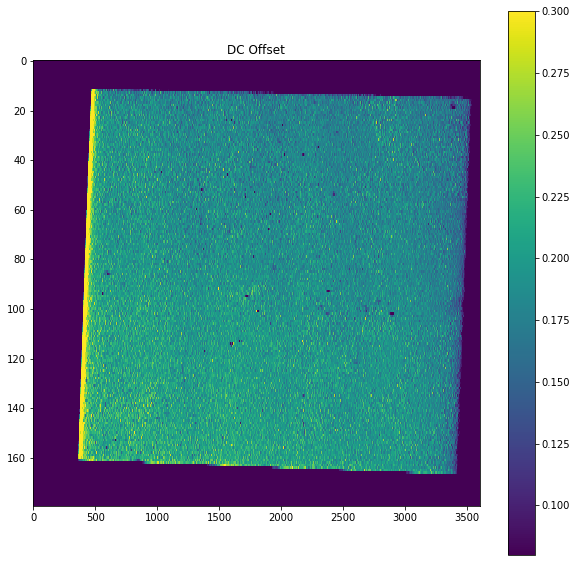

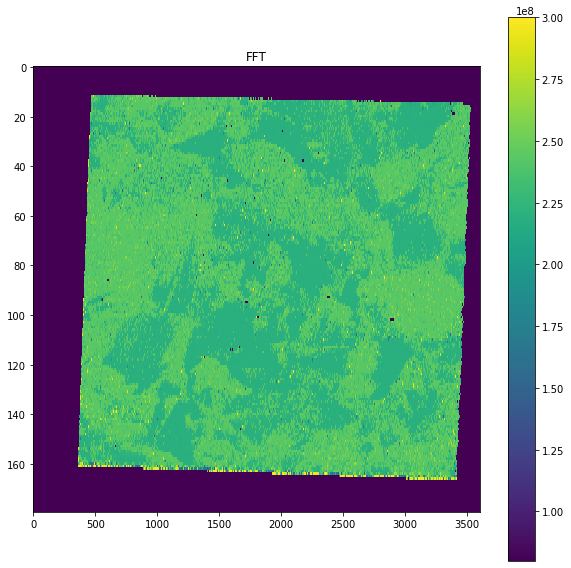

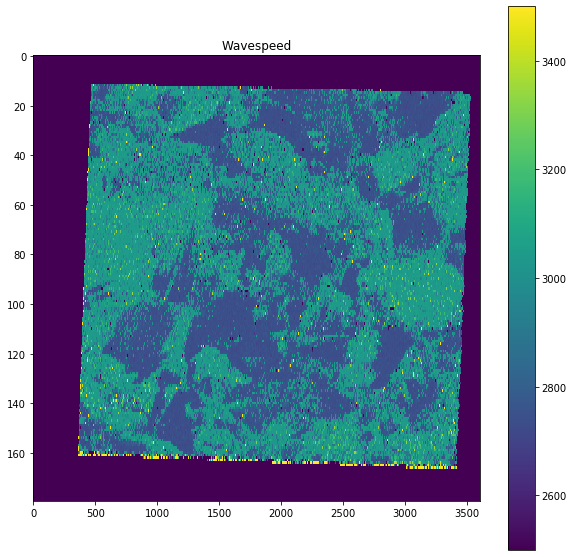

In [11]:
plt.figure(figsize=[10,10])
plt.title("DC Offset")
plt.imshow(mc.map_collections[0].dc_map, aspect=3601/180)
plt.colorbar()
plt.clim([0.080, 0.300])
plt.figure(figsize=[10,10])
plt.title("FFT")
plt.imshow(mc.map_collections[0].rf_map, aspect=3601/180)
plt.colorbar()
plt.clim([80e6, 300e6])
plt.figure(figsize=[10,10])
plt.title("Wavespeed")
plt.imshow(mc.map_collections[0].velocity_map, aspect=3601/180)
plt.colorbar()
plt.clim([2500, 3500])

In [12]:
mc.map_collections[0].velocity_map.iloc[30, 1500] * 12.5E-6

0.034323895533317064

In [13]:
wavefreqs = []
for current in mc.map_collections:
    wavefreqs.append(current.rf_map.iloc[30, 2500])

In [14]:
wfdf = pd.DataFrame([[0, 20, 40, 60, 80, 100, 120, 140, 160], wavefreqs])

In [15]:
mc.map_collections[8].rf_map.to_csv('/home/tka/source/frequencies_180.csv')

In [16]:
mc.map_collections[7].velocity_map = mc.map_collections[7].rf_map * 12.5E-6
mc.map_collections[7].velocity_map.iloc[30, 1500]

2745.911642665365

2745911642.6653647

In [17]:
speeds = pd.Series(wfdf.iloc[1,:] * (12.5E-6))

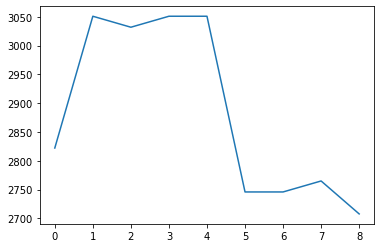

In [18]:
plt.plot(speeds)

In [19]:
mc.map_collections[0].metadata["acq_angle"] = 0
mc.map_collections[1].metadata["acq_angle"] = 20
mc.map_collections[2].metadata["acq_angle"] = 40
mc.map_collections[3].metadata["acq_angle"] = 60
mc.map_collections[4].metadata["acq_angle"] = 80
mc.map_collections[5].metadata["acq_angle"] = 100
mc.map_collections[6].metadata["acq_angle"] = 120
mc.map_collections[7].metadata["acq_angle"] = 140
mc.map_collections[8].metadata["acq_angle"] = 160


(80000000.0, 300000000.0)

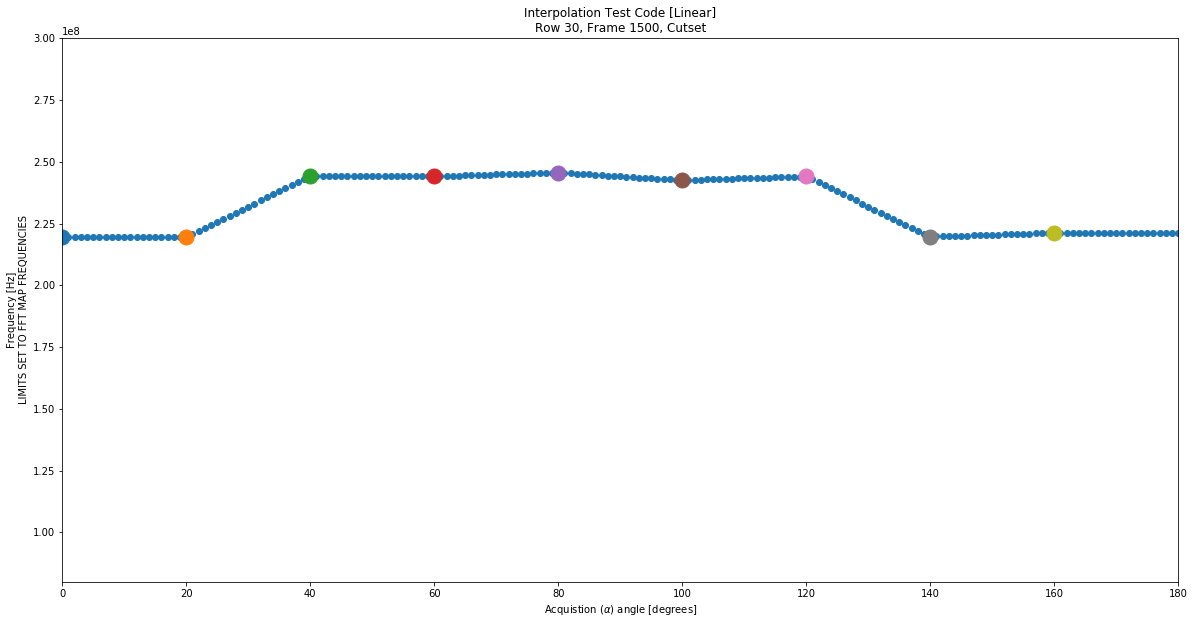

In [20]:
# Create empty array with 0-180 index.
degrees_index = [degree for degree in range(0, 181, 1)]
exp_data = pd.Series(np.nan, index=degrees_index)
# Pull datapoints with acquistion angles from map_collection structure.
for collection in mc.map_collections:
    exp_data[collection.metadata["acq_angle"]] = float(collection.rf_map.loc[30,1500])
# Interpolate the NaN's
interp_exp_data = exp_data.interpolate('linear')

# Plotting Junk
plt.figure(figsize=[20, 10])
plt.scatter(range(0, 181, 1), interp_exp_data)
for collection in mc.map_collections:
    plt.plot(collection.metadata["acq_angle"], collection.rf_map.loc[30,1500], '.', markersize=30)

plt.title("Interpolation Test Code [Linear]\nRow 30, Frame 1500, Cutset")
plt.xlabel(r"Acquistion ($\alpha$) angle [degrees]")
plt.ylabel("Frequency [Hz]\nLIMITS SET TO FFT MAP FREQUENCIES")
plt.xlim([0, 180])
plt.ylim([80e6, 300e6])

In [21]:
exp_data[40]

244081034.903588

In [91]:
import pandas as pd
import numpy as np
class WaveSpeedModel():

    def __init__(self, file_name):

        ''' 
    WavespeedModel(self, file_name): WavespeedModel object. Contains the sorted and row-linked information for a given output CSV file for 
                                     LKFM preprocessor. Expects an absolute path in file_name to the output CSV file.
        '''

        self.file_name = file_name
        self.init_model()
        return

    def init_model(self):
        
        self.csv_dataframe = pd.read_csv(self.file_name)
        # Iterate through the CSV dataframe by row
        _planelist = []
        _amplist = []
        _velocitylist = []
        for row_index in range(0, self.csv_dataframe.shape[0]):
            # Odd case
            if(row_index % 2):
                # Pull off plane information
                _planes = [self.csv_dataframe.iloc[row_index, 1], 
                           self.csv_dataframe.iloc[row_index, 2],
                           self.csv_dataframe.iloc[row_index, 3]]
                # Pull off amplitude v. theta information
                _amps = self.csv_dataframe.iloc[row_index, 5:185]
                _planelist.append(_planes)
                _amplist.append(_amps)
            else:
                # Pull off velocity information, and then convert to m/s
                _velocities = self.csv_dataframe.iloc[row_index, 5:185] * 1000
                _velocitylist.append(_velocities)
            
        # Convert into dataframes. Also fill any NaN's with 0.0 for both amplitude and velocity
        self.planes = pd.DataFrame(_planelist, columns=["x", "y", "z"])
        self.amplitudes = pd.DataFrame(_amplist)
        self.amplitudes = self.amplitudes.reset_index(drop=True)
        self.amplitudes.fillna(0.0)
        self.velocities = pd.DataFrame(_velocitylist)
        self.velocities = self.velocities.reset_index(drop=True)
        self.velocities.fillna(0.0)
        return

    def gaussian_distribution(self, _xinput, _center, _width):
        '''
        gaussian_distribution(self, _xinput, _center, _width): Models a gaussian normal distribution 
                                around _center with _width for a given _xinput
        '''
        prefix = (1 / _width * np.sqrt(2*np.pi))
        return prefix * (np.exp(-0.5*((_xinput-_center)/_width)**2))

    def compare_wavespeed(self, map_collections):
        '''
            compare_wavespeed(self, input_data): Compares input_data list to all known wavespeeds
                                                 in the model. Returns 
        '''
        
        # extract speeds for given row and pixel
        _row = 35
        _pixel = 1500
        # Make angle index list
        self.exp_data = pd.Series(np.nan, index=[degree.__str__() for degree in range(0, 179, 1)])
        self.amp_data = pd.Series(np.nan, index=[degree.__str__() for degree in range(0, 179, 1)])
        # Pull out the experimental data (wavespeed) for the pixel and place
        # in the corresponding alphaslot  according to the metadata['acq_angle'] 
        # attribute of the map_collection.
        for collection in map_collections:
            self.exp_data[collection.metadata["acq_angle"]] = collection.velocity_map.iloc[_row, _pixel]
            self.amp_data[collection.metadata["acq_angle"]] = 1.0
        # Interpolate the experimental data and assign 0.5 amplitude to all interpolated points
        self.exp_data = self.exp_data.interpolate()
        self.amp_data = self.amp_data.fillna(0.5)

        _speedwidth = 100
        _speeddistros = []
        _speedrange = range(2000, 4500, 25)
        for idx in range(0, 179):
            _line = pd.Series(self.gaussian_distribution(_speedrange, self.exp_data[idx], _speedwidth) * self.amp_data[idx])
            _speeddistros.append(_line)
        
        _speeddistros = pd.DataFrame(_speeddistros)
        # Transpose then row reverse dataframe so imshow works correctly if used.
        _speeddistros = _speeddistros.T
        _speeddistros = _speeddistros.values[::-1]

        # Pull model data for a plane
        _modelspeeds = self.velocities.loc[0]
        
        return _speeddistros, _modelspeeds


In [92]:
model_file = '/home/tka/source/data/TiAlpha_Mode0Only.csv'
ws = WaveSpeedModel(model_file)
ws.init_model()

speeddistros, modelspeeds = ws.compare_wavespeed(mc.map_collections)


In [45]:
modelspeeds = np.array(modelspeeds)

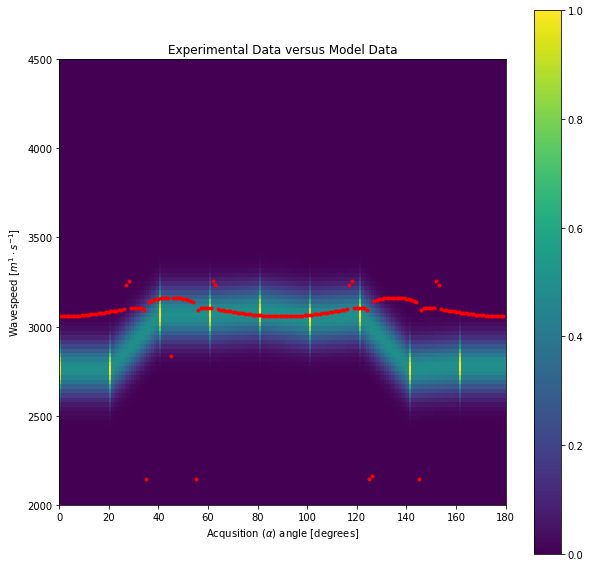

In [47]:
plt.figure(figsize=[10, 10])
plt.title("Experimental Data versus Model Data")
# normalize speed distribution data.
speeddistros = (speeddistros - np.min(speeddistros)) / (np.max(speeddistros) - np.min(speeddistros))
plt.imshow(speeddistros, extent=[0, 180, 2000, 4500], aspect=180/2500)
plt.plot(range(0, 180), modelspeeds, '.', color='red')
#plt.plot(range(0, 180), cut_exp_speeds, '*', color='yellow')
plt.ylabel(r"Wavespeed [$m^{1} \cdot s^{-1}$]")
plt.xlabel(r"Acqusition ($\alpha$) angle [degrees]")
plt.xlim(0, 180)
plt.ylim(2000, 4500)
plt.colorbar()


In [52]:
ws.exp_data.shape

(179,)

In [96]:
from tqdm.notebook import tqdm
planelist = []
for rowidx in tqdm(range(0, ws.velocities.shape[0])):    
    modelspeeds = np.array(ws.velocities.loc[rowidx])
    anglefitness = []
    for rollangle in range(0, 179):
        fitness = []
        modelspeeds = np.roll(modelspeeds, 1)
        for angle in range(0,179):
            fitness.append(ws.gaussian_distribution(modelspeeds[angle], ws.exp_data[angle], 20))

        fitness = np.array(fitness)
        anglefitness.append(fitness.sum())
        #print("Fitness score: {0}".format(fitness.sum()))

    anglefitness = pd.Series(anglefitness)
    planelist.append([anglefitness.max(), anglefitness.argmax()])

In [97]:
planelist = pd.DataFrame(planelist)

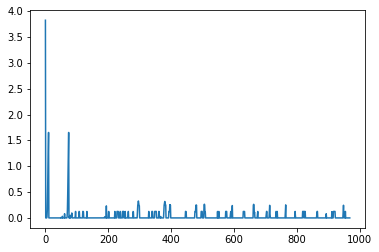

In [98]:
plt.plot(planelist.iloc[:,0])

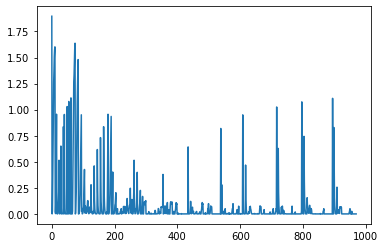

In [95]:
planelist = pd.DataFrame(planelist)
plt.plot(planelist.iloc[:,0])

Max Fitness of 2.0024 at 130 degrees.


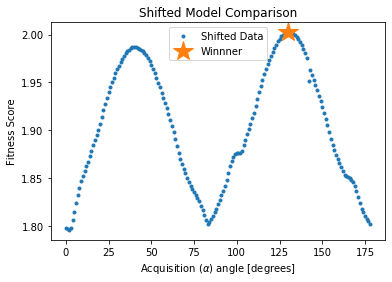

In [74]:
modelspeeds = np.array(modelspeeds)
anglefitness = []
for rollangle in range(0, 179):
    fitness = []
    modelspeeds = np.roll(modelspeeds, 1)
    for angle in range(0,179):
        fitness.append(ws.gaussian_distribution(modelspeeds[angle], ws.exp_data[angle], 100))

    fitness = np.array(fitness)
    anglefitness.append(fitness.sum())
    #print("Fitness score: {0}".format(fitness.sum()))

anglefitness = pd.Series(anglefitness)
plt.plot(anglefitness, '.')
plt.plot(anglefitness.argmax(), anglefitness.max(), '*', markersize=20)
plt.legend(["Shifted Data", "Winnner"])
plt.title("Shifted Model Comparison")
plt.ylabel("Fitness Score")
plt.xlabel(r"Acquisition ($\alpha$) angle [degrees]")
print("Max Fitness of {0:.4f} at {1} degrees.".format(anglefitness.max(), anglefitness.argmax()))

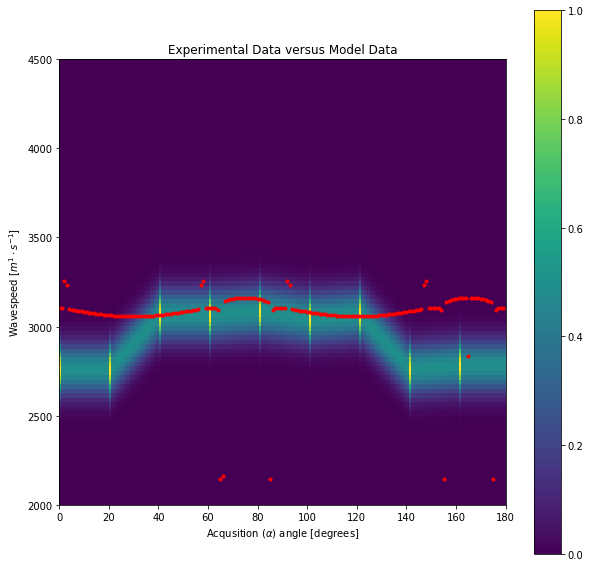

In [63]:
plt.figure(figsize=[10, 10])
plt.title("Experimental Data versus Model Data")
# normalize speed distribution data.
speeddistros = (speeddistros - np.min(speeddistros)) / (np.max(speeddistros) - np.min(speeddistros))
plt.imshow(speeddistros, extent=[0, 180, 2000, 4500], aspect=180/2500)
plt.plot(range(0, 180), np.roll(modelspeeds, 122), '.', color='red')
#plt.plot(range(0, 180), cut_exp_speeds, '*', color='yellow')
plt.ylabel(r"Wavespeed [$m^{1} \cdot s^{-1}$]")
plt.xlabel(r"Acqusition ($\alpha$) angle [degrees]")
plt.xlim(0, 180)
plt.ylim(2000, 4500)
plt.colorbar()

x    0.0
y    0.0
z    1.0
Name: 0, dtype: float64

Prototype code for new wavespeedmodel
```
ws.init_model()
ws.csv_dataframe

_planelist = []
_amplist = []
# Iterate through the csv dataframe by row
for x in range(0, ws.csv_dataframe.shape[0]):
    # if line number is odd, pull amplitudes. use this line for the planes because this case came first
    if (x % 2):
        planes = [ws.csv_dataframe.iloc[x,1], ws.csv_dataframe.iloc[x,2], ws.csv_dataframe.iloc[x, 3]]
        _amplist.append(ws.csv_dataframe.iloc[x, 5:185])
        _planelist.append(planes)
# create dataframes
planes = pd.DataFrame(_planelist, columns=["x", "y", "z"])
# reset the index column so it doesn't go 1, 3, 5, 7, etc.
amps = pd.DataFrame(_amplist)
amps = amps.reset_index(drop=True)
```


In [302]:
sample_pixel = 500
sample_row = 140
sample_x = 34.0 + (sample_pixel/3601)*18.0
sample_y = 30.0 + (sample_row/180)*18.0
sample_name = "Sample 04"

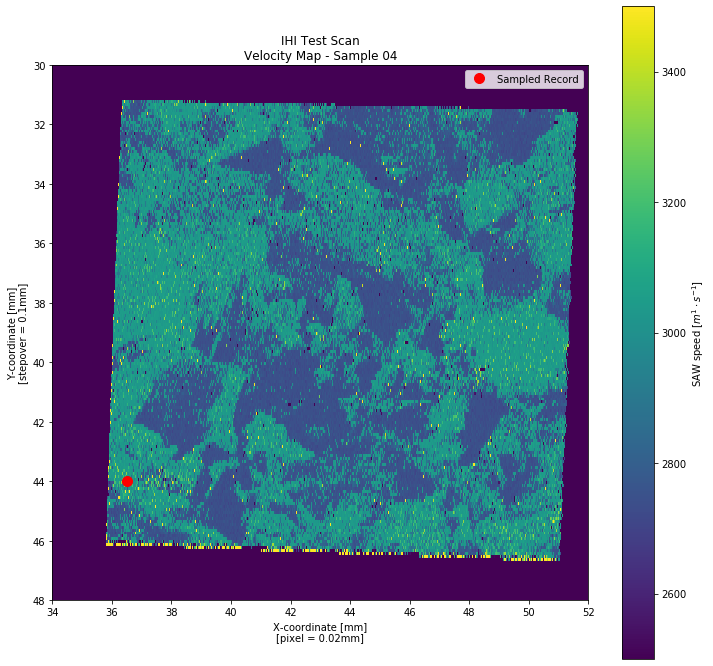

In [303]:
fileprefix = '/home/tka/source/data/'
plt.figure(figsize=[12, 12])
plt.imshow(mc.map_collections[0].velocity_map, extent=[34.0, 52.0, 48.0, 30.0])
plt.title("IHI Test Scan\nVelocity Map - " + sample_name)
plt.clim(2500, 3500)
velbar = plt.colorbar()
velbar.set_label(r"SAW speed [$m^{1} \cdot s^{-1}$]")
plt.ylabel("Y-coordinate [mm]\n[stepover = 0.1mm]")
plt.xlabel("X-coordinate [mm]\n[pixel = 0.02mm]")
plt.plot(sample_x, sample_y, '.', markersize=20, color='Red')
plt.legend(["Sampled Record"])
plt.savefig(fileprefix + 'map-sample04.png')

In [304]:
velocities = []
angles = []
exp_data_array = []
exp_angles = [x for x in range(0,180)]
exp_data_array = np.empty(180)
exp_data_array[:] = np.nan
for collection in mc.map_collections:
    angles.append(collection.metadata["acq_angle"])
    velocities.append(collection.velocity_map.iloc[sample_row, sample_pixel])
    exp_data_array[int(collection.metadata["acq_angle"])] = collection.velocity_map.iloc[sample_row, sample_pixel]

exp_data_array = pd.DataFrame(exp_data_array)
exp_data_array = exp_data_array.interpolate()

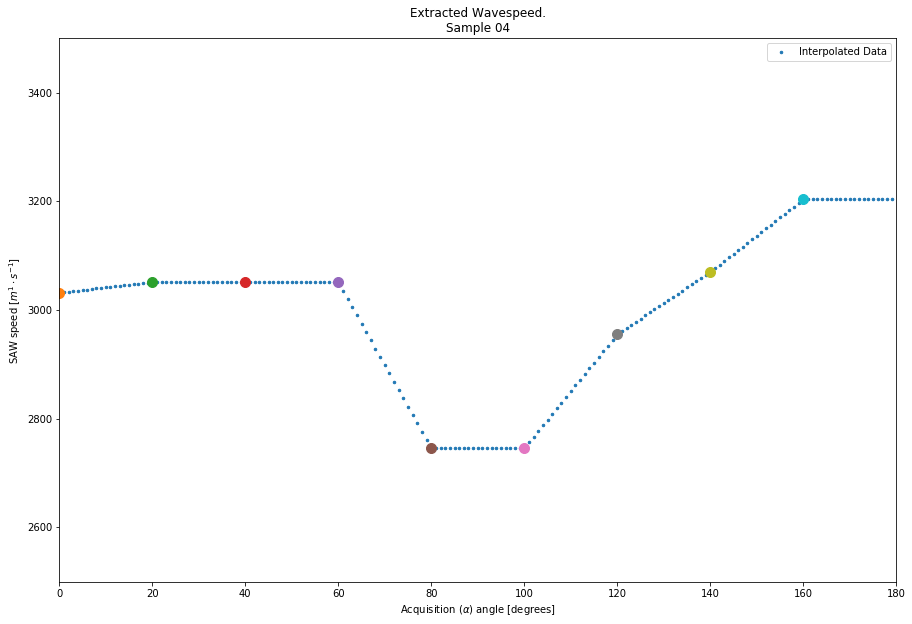

In [305]:
plt.figure(figsize=[15, 10])
plt.title("Extracted Wavespeed.\n" + sample_name)
plt.plot(exp_data_array, '.', markersize=5)
plt.legend(["Interpolated Data"])
for current in range(0, angles.__len__()):
    plt.plot(angles[current], velocities[current], '.', markersize=20)
plt.xlim(0, 180)
plt.ylim(2500, 3500)
plt.xlabel(r"Acquisition ($\alpha$) angle [degrees]")
plt.ylabel(r"SAW speed $[m^{1} \cdot s^{-1}$]")
plt.savefig(fileprefix + 'velocitychart-sample04.png')

In [306]:
inputspeeds = [x for x in range(2500, 3500, 5)]
speedanglebins = []
spread = 10
for current in range(0, exp_data_array.shape[0]):
    binspeeds = []
    for idx in range(0, inputspeeds.__len__()):
        binspeeds.append(ws.gaussian_distribution(float(inputspeeds[idx]), float(exp_data_array.loc[current]), spread))

    speedanglebins.append(binspeeds)
speedanglebins = pd.DataFrame(speedanglebins)
speedanglebins = speedanglebins.T
speedanglebins = speedanglebins[::-1]

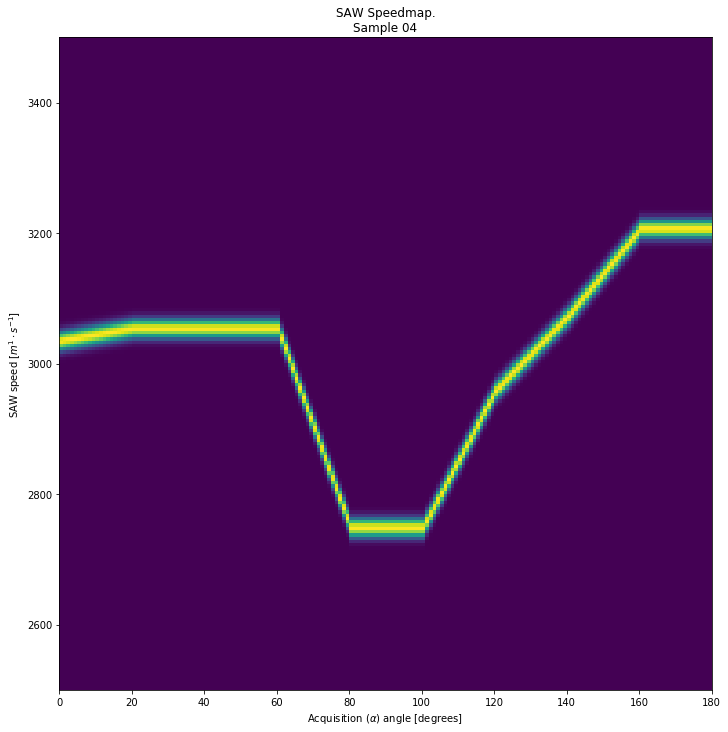

In [307]:
plt.figure(figsize=[12, 12])
plt.title("SAW Speedmap.\n" + sample_name)
plt.imshow(speedanglebins, extent=[0, 180, 2500, 3500], aspect=180/1000)
plt.xlabel(r"Acquisition ($\alpha$) angle [degrees]")
plt.ylabel(r"SAW speed $[m^{1} \cdot s^{-1}$]")
plt.savefig(fileprefix + 'velocitymap-sample04.png')